# Workshop -- Machine learning in life sciences
### What is it, when should it be used and how to avoid common pitfalls

**Author:** Benjamin Goudey, Research Fellow in Florey Department of Neuroscience and Mental Health at The University of Melbourne

**Last updated:** 19/08/2024

# Introduction
Welcome to the workshop! This notebook accompanies the workshop *Applying machine learning in life sciences: what does it mean and how to avoid common traps.*

The notebook focuses on the problem of predicting diabetes from a few clinical and blood measurements, as well as several simulated variables that are not correlated with the outcome.

The notebook is split into into four sections. 

0. Welcome and setup
1. Exploring the data and fitting a model and measuring performance
2. Pitfall 1: Evaluation frameworks and generalisation
3.  Pitfall 2: Selecting features and model parameters

There will be a number of models, measures and algorithms that will be used and will be briefly explained in the accompanying tutorial but will not be covered in detail. The skikit-learn documentation will be valuable here (https://scikit-learn.org/stable/modules/classes.html)

The notebook assumes familiarity with Python, and a passing familiarity with the pandas, matplotlib/seaborn and numpy/scipy packages. But even if you don't have this, the idea is that this notebook should help you get an idea of some of the concepts around machine learning and may be a useful resource for you at some stage. 

**Please note:** the expectation is you should be able to follow along rather than write this code from scratch. You should be able to run each cell in the notebook to get an output and then comments should direct you to indicate which parameters to change. If you get stuck, let us know!

# 0 Package Setup and Data Loading

Don't worry too much about the code in this section. We load in the necessary packages and then there are a number of functions to load in the data or plot outputs. The details of these are mostly not needed for this workshop and I'll step through in more detail when they are needed. 

## 0.1 Install and load required packages

<div class="alert alert-block alert-warning">
**Warning:** you may need to run this cell twice

It installs a recent version of ydata-profiling, a tool for summarising the content of a pandas data frame. When the install occurs, a little reset button may appear. Press this and re-run the cell to load all packages into your environment.
</div>

In [151]:
%pip install ydata_profiling
%matplotlib inline

# Load in everything we need
# If you are playing along on your local machine, you need to run 
#     pip install pandas numpy scikit-learn graphviz matplotlib seaborn ydata_profiling ipywidgets
# to download and install the libraries first
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, cross_val_score, RepeatedKFold, KFold, GridSearchCV
from sklearn import datasets
from sklearn import metrics
from sklearn import feature_selection
from sklearn import linear_model
from sklearn.metrics import roc_auc_score
from sklearn.pipeline import make_pipeline
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.base import clone

import graphviz 

# Models
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, Lasso

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns

# Pandas-profiling - generates an interactive report
from ydata_profiling import ProfileReport


Note: you may need to restart the kernel to use updated packages.


## 0.2 Loading helper function

In [2]:
import workshop_fn

## 0.3 Data loading

In [3]:
# assigning url to a variable
url="https://raw.githubusercontent.com/bwgoudey/IntroMLforLifeScienceWorkshopR/main/RC_health_data_n2000.csv"
 # passing parameter to the function
diabetes_df_raw =pd.read_csv(url)

In [4]:
diabetes_df_raw

,id,age_y,gender_1_male_2_female,site,height_cm,weight_kg,bmi_kg_m2,sbp_mm_hg,dbp_mm_hg,fpg_mmol_l,cholesterol_mmol_l,triglyceride_mmol_l,hdl_c_mmol_l,ldl_mmol_l,alt_u_l,bun_mmol_l,ccr_umol_l,year_of_followup,diabetes
0,11550,60,2,5,160.0,64.0,25.0,119,75,4.77,5.30,0.50,1.31,3.29,19.0,7.04,68.0,3.756331,0
1,8254,81,1,5,169.0,66.0,23.1,141,60,5.25,4.90,0.60,1.24,2.94,21.0,6.19,91.0,3.775496,0
2,646385,91,1,5,163.0,59.0,22.2,123,63,6.20,5.50,1.10,1.50,3.31,12.0,7.22,87.0,2.844627,0
3,7138,58,2,5,170.0,66.0,22.8,133,77,5.54,5.60,3.60,1.46,3.20,26.0,3.26,62.0,2.028747,0
4,25112,73,1,5,161.0,64.0,24.7,125,73,4.03,5.80,1.30,1.62,3.06,9.0,5.07,83.0,3.917864,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3261,681772,64,2,5,152.0,78.0,33.8,160,80,6.60,5.10,1.10,1.59,2.93,48.0,4.42,46.0,3.863107,1
3262,682796,61,1,5,169.0,80.0,28.0,129,86,6.79,4.90,1.30,1.41,2.75,19.0,7.54,104.0,2.012320,1
3263,683831,57,1,5,173.0,66.0,22.1,134,94,6.48,5.00,1.60,1.26,2.98,34.0,4.87,92.0,3.022587,1
3264,683911,69,1,5,176.0,84.0,27.1,133,73,6.99,3.60,1.10,1.42,1.83,43.0,6.30,91.0,3.854894,1


# Session 1: Exploring the data and fitting a basic model

Here, we will explore a given dataset related to diabetes and fit a basic model using the scikit-learn package.

In particular, we aim to
 - understand the dataset, its variables and their relationship. 
 - introduce the pandas-profiling and scikit-learn packages. 
 - demonstrate how to fit a model using sklearn and look at the outputs. 

## Background: Dataset


There are 17 measurements in the original study that we make use of here.


| Column Name              | Meaning                                   | Units                                    |
|--------------------------|-------------------------------------------|------------------------------------------|
| Age (y)                  | Age of the participant                    | Years                                    |
| Gender(1, male; 2, female)| Gender of the participant                | Categorical (1 = Male, 2 = Female)       |
| site                     | Study site/location                       | Categorical                              |
| height(cm)               | Height of the participant                 | Centimeters (cm)                         |
| weight(kg)               | Weight of the participant                 | Kilograms (kg)                           |
| z                        | Body Mass Index (unstandardized)          | Kilograms per Square Meter (kg/m²)       |
| SBP(mmHg)                | Systolic Blood Pressure                   | Millimeters of Mercury (mmHg)            |
| DBP(mmHg)                | Diastolic Blood Pressure                  | Millimeters of Mercury (mmHg)            |
| FPG (mmol/L)             | Fasting Plasma Glucose                    | Millimoles per Liter (mmol/L)            |
| Cholesterol(mmol/L)      | Total Cholesterol                         | Millimoles per Liter (mmol/L)            |
| Triglyceride(mmol/L)     | Triglycerides                             | Millimoles per Liter (mmol/L)            |
| HDL-c(mmol/L)            | High-Density Lipoprotein Cholesterol      | Millimoles per Liter (mmol/L)            |
| LDL(mmol/L)              | Low-Density Lipoprotein                   | Millimoles per Liter (mmol/L)            |
| ALT(U/L)                 | Alanine Aminotransferase                  | Units per Liter (U/L)                    |
| AST(U/L)                 | Aspartate Aminotransferase                | Units per Liter (U/L)                    |
| BUN(mmol/L)              | Blood Urea Nitrogen                       | Millimoles per Liter (mmol/L)            |
| CCR(umol/L)              | Creatinine Clearance Rate                 | Micromoles per Liter (umol/L)            |

Additionally, when loading in the data, we will be exploring the impact of randomly generated features that are not associated with your outcome. Such measurements are often generated in high-throughput 'omics studies where many things are measured that are not known to be associated.

### Analysis aim

The analysis goals from this dataset were "inference" based, i.e. trying to understand a relationship:

> We investigated the association between body mass index (BMI) and diabetes across a wide range of age groups.

For the purposes of this workshop, we'll assume the equivalent predictive question **"does BMI improve prediction of incident diabetes between 2 and 7 years from onset beyond age, sex, and blood glucose?"**. Now we have a specific baseline we can evaluate against.

As a secondary goal, we'll investigate the maximum predictive performance we can achieve with this dataset, with a strong focus on generalization, i.e that the prediction will hold for new data. 

For those who are interested, the full study is available at https://datadryad.org/stash/dataset/doi:10.5061/dryad.ft8750v

 

## 1.1 Load in the data
We will load in a cleaned-up version of the dataset (using the *load_diabetes_data()* function).

In [136]:
# This cell creates of the dataframe that has been entered. 
X,y,X_ext,y_ext = workshop_fn.load_diabetes_data(diabetes_df_raw, add_n_features=10, sample_limit=1000)



/mnt/4TBv2/Research/Workshops/IntroMLforLifeScienceWorkshopPython/workshop_fn.py:90: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .apply(lambda x: x.head(np.ceil(sample_limit / 2).astype(int)))


## 1.2 Data exploration
We'll begin by exploring the data that is available. While we have a description of the fields, understanding the relationships between individual features and their relationship with the outcome of interest is informative for helping to understand downstream. 

Rather than try to generate a bunch of plots manually, we can make use of a package called *pandas-profiling*, which provides a bunch of handy plots. *This will take a minute or two to run*. After that a small report below will be generated that provides an overview of the different features and their relationships. 

**Examine the following:**

1. What are the different types of features - which are numerical? which are categorical? are any unclear?
2. Which features are correlated with each other? How strong are these?
3. Is there anything unexpected about the data?
4. Is there any missing data?
5. What does the target variable look like? What is its distribution? Are there any obvious relationships?



In [72]:
X_y = X.iloc[:, 0:20].assign(y = y)
X_y

,age_y,gender_1_male_2_female,height_cm,weight_kg,bmi_kg_m2,sbp_mm_hg,dbp_mm_hg,fpg_mmol_l,cholesterol_mmol_l,triglyceride_mmol_l,...,ldl_mmol_l,alt_u_l,bun_mmol_l,ccr_umol_l,simulated_0,simulated_1,simulated_2,simulated_3,simulated_4,y
0,0.277740,2,-0.704724,-0.405048,0.040491,-0.523806,-0.330845,-0.955525,0.394330,-0.979583,...,0.715573,-0.306921,1.601903,-0.582237,-0.888126,-0.875872,1.423472,0.733331,-1.079142,0
1,1.891657,1,0.343233,-0.237718,-0.543290,0.634668,-1.617303,-0.274938,-0.048252,-0.896560,...,0.172565,-0.232635,0.929527,0.801069,-1.642889,-0.636791,-1.703625,0.665665,-0.097700,0
2,2.660189,1,-0.355405,-0.823373,-0.819818,-0.313174,-1.360012,1.072056,0.615621,-0.481450,...,0.746602,-0.566920,1.744289,0.560494,-0.831922,-0.518396,1.656595,-0.392631,-0.828650,0
3,0.124033,2,0.459673,-0.237718,-0.635466,0.213405,-0.159317,0.136249,0.726266,1.594104,...,0.575943,-0.046921,-1.388194,-0.943099,0.797356,-0.804644,-0.840272,-0.484348,-0.935603,0
4,1.276831,1,-0.588285,-0.405048,-0.051685,-0.207858,-0.502373,-2.004762,0.947557,-0.315405,...,0.358739,-0.678349,0.043572,0.319919,0.925514,-1.595942,1.584657,-0.724871,-0.962330,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0.277740,2,-1.112264,-1.074368,-0.604741,0.371378,-0.673900,1.610853,1.379075,0.780487,...,1.149980,-0.269778,0.059393,-1.243818,-1.084040,0.041477,0.403612,-0.734912,0.167101,1
996,0.738859,2,-0.821164,0.933592,2.068364,0.266063,-0.502373,0.263859,-0.048252,-0.232383,...,0.420797,-0.492635,-0.011800,-0.281518,-0.474678,-0.504528,-1.262535,1.362482,0.080619,1
997,-0.644499,2,-1.286923,0.431602,1.822561,0.266063,0.012211,0.490721,-1.066191,-0.398428,...,-1.471976,0.213079,0.842514,-1.664824,0.422213,0.452108,0.653822,-1.457470,-1.052945,1
998,0.585153,1,0.983652,0.724430,0.194118,2.319719,0.612558,1.951147,0.051329,-0.423334,...,-0.448017,-0.158349,1.902495,1.342363,0.112832,1.495593,0.436959,-1.544703,0.729498,1


In [73]:
# Ignore most of the simulated features for this exploration
X_y = X.iloc[:, 0:20].assign(y = y)
profile = ProfileReport(X_y, 
                       correlations={
        "pearson": {"calculate": False},
        "spearman": {"calculate": True},
        "kendall": {"calculate": False},
        "phi_k": {"calculate": True},
        "cramers": {"calculate": False},
    })

#profile.to_widgets()
# The line above makes nice looking output but I think it is broken in either Google Colab or Python notebooks. 
profile.to_notebook_iframe()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

KeyboardInterrupt: 

## 1.3 Fitting a model to the data

Lets fit a simple logistic regression to the data and look at how well it makes predictions on the data. The code below will fit a simple logistic regression , using only a single predictor (bmi), to allow for simple plots of the fit, and then using all available features. 

We begin by plotting the data, the model fit and some classic summary statistics. 

*Questions*:
1.  Which features are the most predictive?
2.  How much improvement to you get if you combined features compared to a model based on individual features?
3.  Try regenerating the dataset with more or less simulated. What happens to prediction accuracy as you add more noisy variables?
4. The `scale` parameter in  load_diabetes_data determines whether we normalize our variables so they have a mean of 0 and a standard deviation of 1. What happens when we set this to True or False?

 Note: the data has a bunch of variables called simulated<number> e.g simulated_1, simulated_2 etc. These are just randomly generated numbers. But in real life these types of variables do exist - they are essentially any variable that is unrelated to the thing we are trying to predict. In this data, we explicitly know these simulated variables but in your own datasets (and for the other variables in the diabetes dataset), we have no idea which variables are related and which are not. 
 


/mnt/4TBv2/Research/Workshops/IntroMLforLifeScienceWorkshopPython/workshop_fn.py:90: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .apply(lambda x: x.head(np.ceil(sample_limit / 2).astype(int)))


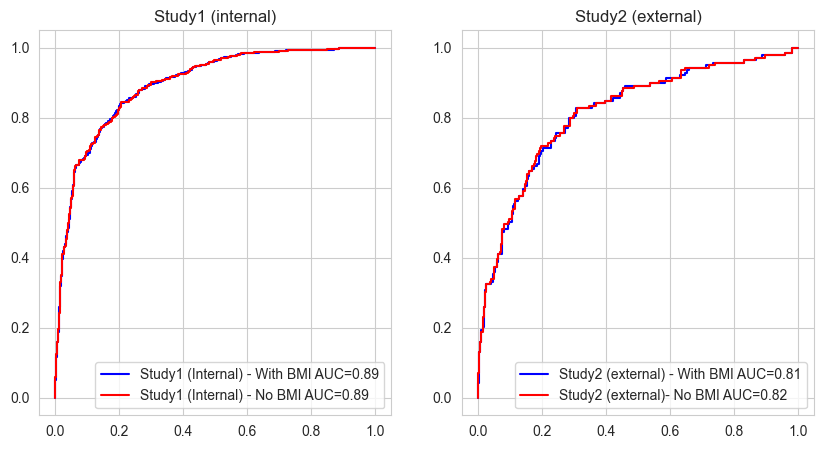

In [155]:

# If you feel like generating a new dataset, uncomment this line. 
X,y,X_ext,y_ext = workshop_fn.load_diabetes_data(diabetes_df_raw, add_n_features=100, sample_limit=1000, scale=True)

# The features used to construct the model
# Change these and see how the results change
# This option would include all features
features= X.columns

# We can also look at models with BMI and one other feature
#features=["bmi_kg_m2", "fpg_mmol_l"]
#features=["bmi_kg_m2", "age_y"]
#features=["bmi_kg_m2", "simulated_1"]

# This set will include 4 features
#features=["age_y", "gender_1_male_2_female", "bmi_kg_m2", "fpg_mmol_l"]


# sklearn models expect a 2D array. However, when only a single column is selected in pandas, it is a
# 1D array. This conditional checks for when our input is a single column and turns it into a 2D array for sklearn.  
if type(features)==str:
    X_train    = X.loc[:, features].values.reshape(-1,1)
    X_eval = X_ext.loc[:, features].values.reshape(-1,1)
else:
    X_train    = X.loc[:, features]
    X_eval = X_ext.loc[:, features]
        
#Construct a classifier
clf = LogisticRegression(penalty=None, solver="saga", tol=0.01)

clf_w_bmi = clone(clf).fit(X_train, y)
clf_no_bmi = clone(clf).fit(X_train.drop(columns=['bmi_kg_m2']), y)

# Get predicted labels from the classifier. Here, the 'predict_proba' function returns probabilities of the labels (e.g 75% of belonging to class 1)
# get predictions when given the training data
y_pred = clf_w_bmi.predict_proba(X_train)[:,1]
y_pred_no_bmi = clf_no_bmi.predict_proba(X_train.drop(columns=['bmi_kg_m2']))[:,1]

# get predictions when given the evaluation data
y_ext_pred = clf_w_bmi.predict_proba(X_eval)[:,1]
y_ext_pred_no_bmi = clf_no_bmi.predict_proba(X_eval.drop(columns=['bmi_kg_m2']))[:,1]


fig, ax=plt.subplots(nrows=1,ncols=2, figsize=(10,5), dpi= 100, facecolor='w', edgecolor='k')

# PLot a ROC curve and show the area under the curve. 
workshop_fn.plot_roc(y, y_pred, ax=ax[0], label="Study1 (Internal) - With BMI")
workshop_fn.plot_roc(y, y_pred_no_bmi, ax=ax[0], label="Study1 (Internal) - No BMI", color='red')
workshop_fn.plot_roc(y_ext, y_ext_pred, ax=ax[1], label="Study2 (external) - With BMI")
workshop_fn.plot_roc(y_ext, y_ext_pred_no_bmi, ax=ax[1], label="Study2 (external)- No BMI", color='red')
ax[0].legend(loc=0)
ax[0].title.set_text('Study1 (internal)')
ax[1].legend(loc=0)
ax[1].title.set_text('Study2 (external)')


## 1.4 Examine top features
Logistic regression provides an interpretable model. To see which features are most important, we can look at the coefficients of each variable. Larger absolute values implies more impact in the predictions. 


**Examine the following:**

1. Do any simulated variables make it into the top 10?
2. What if you generate lots of simulated variables (>1000)? What if we have less?


In [161]:
coefs_df = pd.DataFrame.from_dict({'feature':features, 'coef':clf_w_bmi.coef_[0]})
coefs_df.sort_values(by="coef", key=np.abs, ascending=False).iloc[0:15, :]

,feature,coef
7,fpg_mmol_l,1.52
4,bmi_kg_m2,0.44
2,height_cm,-0.35
9,triglyceride_mmol_l,0.33
11,ldl_mmol_l,-0.32
10,hdl_c_mmol_l,0.31
86,simulated_71,0.25
13,bun_mmol_l,-0.23
46,simulated_31,-0.21
17,simulated_2,0.20


<hr style="border:2px solid gray"> </hr>

# Session 2: models and metrics in sklearn

In the previous example, we fit a logistic regression model to the given dataset and examine its performance using AUC. However, in many studies where we are looking to create a predictive model, we will be interested in creating multiple models based on different underlying algorithms and possibly evaluating them based on different criteria. Here, we demonstrate how these different models and metrics can be called and provide a few examples with our diabetes dataset as to the information you get.      

## 2.1 Exploring different models
The sklearn has quite a standardised interface for fitting and applying different models. In particular clf.fit(X, y) and clf.predict_proba(X) can be used to fit a model and then extract the probabilities of the predicted classes. Comparable functions exist when looking at continuous or multi-label outcomes. 

These standardised interfaces allow us to easily explore the impact of different classifiers for a problem. UNderstanding the different assumptions and methods is beyond this workshop. However, we can explore how this is done and talk through the impact of diffent classifiers. 


**Examine the following:**

1. How well do different classifiers perform on the given dataset? Which models maximise performance on the training set? What does external performance look like?
2. Are there noticable timing differences?
3. Model configuration can have a big impact. For LogisticRegression(penalty='l1'), try changing the C to 1e-1, 1e-2, and 1e-3. How does performance change?

/mnt/4TBv2/Research/Workshops/IntroMLforLifeScienceWorkshopPython/workshop_fn.py:90: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .apply(lambda x: x.head(np.ceil(sample_limit / 2).astype(int)))


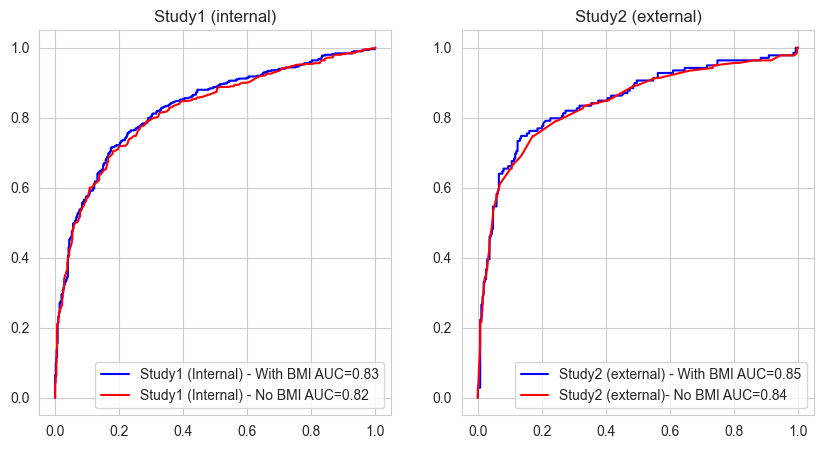

In [162]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

#X,y,X_ext,y_ext = workshop_fn.load_diabetes_data(diabetes_df_raw, add_n_features=100, sample_limit=1000, scale=True)


#
# Change these options to change your classifier
#
#clf=LogisticRegression(penalty=None, solver="saga", tol=0.01)
clf=LogisticRegression(penalty='l1',C=1e-2, solver='saga')
#clf=RandomForestClassifier(max_depth=1, random_state=0)
#clf=DecisionTreeClassifier(max_depth=None, random_state=0)



# This code is all the same as in Section 1.3 
clf_w_bmi = clone(clf).fit(X_train, y)
clf_no_bmi = clone(clf).fit(X_train.drop(columns=['bmi_kg_m2']), y)

# Get predicted labels from the classifier. Here, the 'predict_proba' function returns probabilities of the labels (e.g 75% of belonging to class 1)
# get predictions when given the training data
y_pred = clf_w_bmi.predict_proba(X_train)[:,1]
y_pred_no_bmi = clf_no_bmi.predict_proba(X_train.drop(columns=['bmi_kg_m2']))[:,1]

# get predictions when given the evaluation data
y_ext_pred = clf_w_bmi.predict_proba(X_eval)[:,1]
y_ext_pred_no_bmi = clf_no_bmi.predict_proba(X_eval.drop(columns=['bmi_kg_m2']))[:,1]


fig, ax=plt.subplots(nrows=1,ncols=2, figsize=(10,5), dpi= 100, facecolor='w', edgecolor='k')

# PLot a ROC curve and show the area under the curve. 
workshop_fn.plot_roc(y, y_pred, ax=ax[0], label="Study1 (Internal) - With BMI")
workshop_fn.plot_roc(y, y_pred_no_bmi, ax=ax[0], label="Study1 (Internal) - No BMI", color='red')
workshop_fn.plot_roc(y_ext, y_ext_pred, ax=ax[1], label="Study2 (external) - With BMI")
workshop_fn.plot_roc(y_ext, y_ext_pred_no_bmi, ax=ax[1], label="Study2 (external)- No BMI", color='red')
ax[0].legend(loc=0)
ax[0].title.set_text('Study1 (internal)')
ax[1].legend(loc=0)
ax[1].title.set_text('Study2 (external)')


## 2.2 Example of a specific model output
Different machine learning methods have very different underlying algorithms and can produce very different outputs. 

Below we take an example at a unique output, that of a decision tree, to peek into how it works. Here, the model produces a sort of flowchart for how a sample should be classifier, based on a series of binary decisions. We visualise this model below where each node shows
1. A variable chosen to make a decision and a threshold for which side of the subtree we go down
2. gini value, a measure of how well the given split separates classes (lower is more discriminative)
3. samples is the number of samples in a node in the training data
4. values is the number of samples in each class in the training data (sum of 'values' is the same as 'samples')

**Examine the following:**
1. What happens when we have more or less noise variables in the data? Do they make it into the tree?
2. What if we make the tree bigger or smaller (n=1 or n=5)? How do you think the model will perform
3. Try make the max_depth=7. Is the tree still interpretable? How many noise variables are included

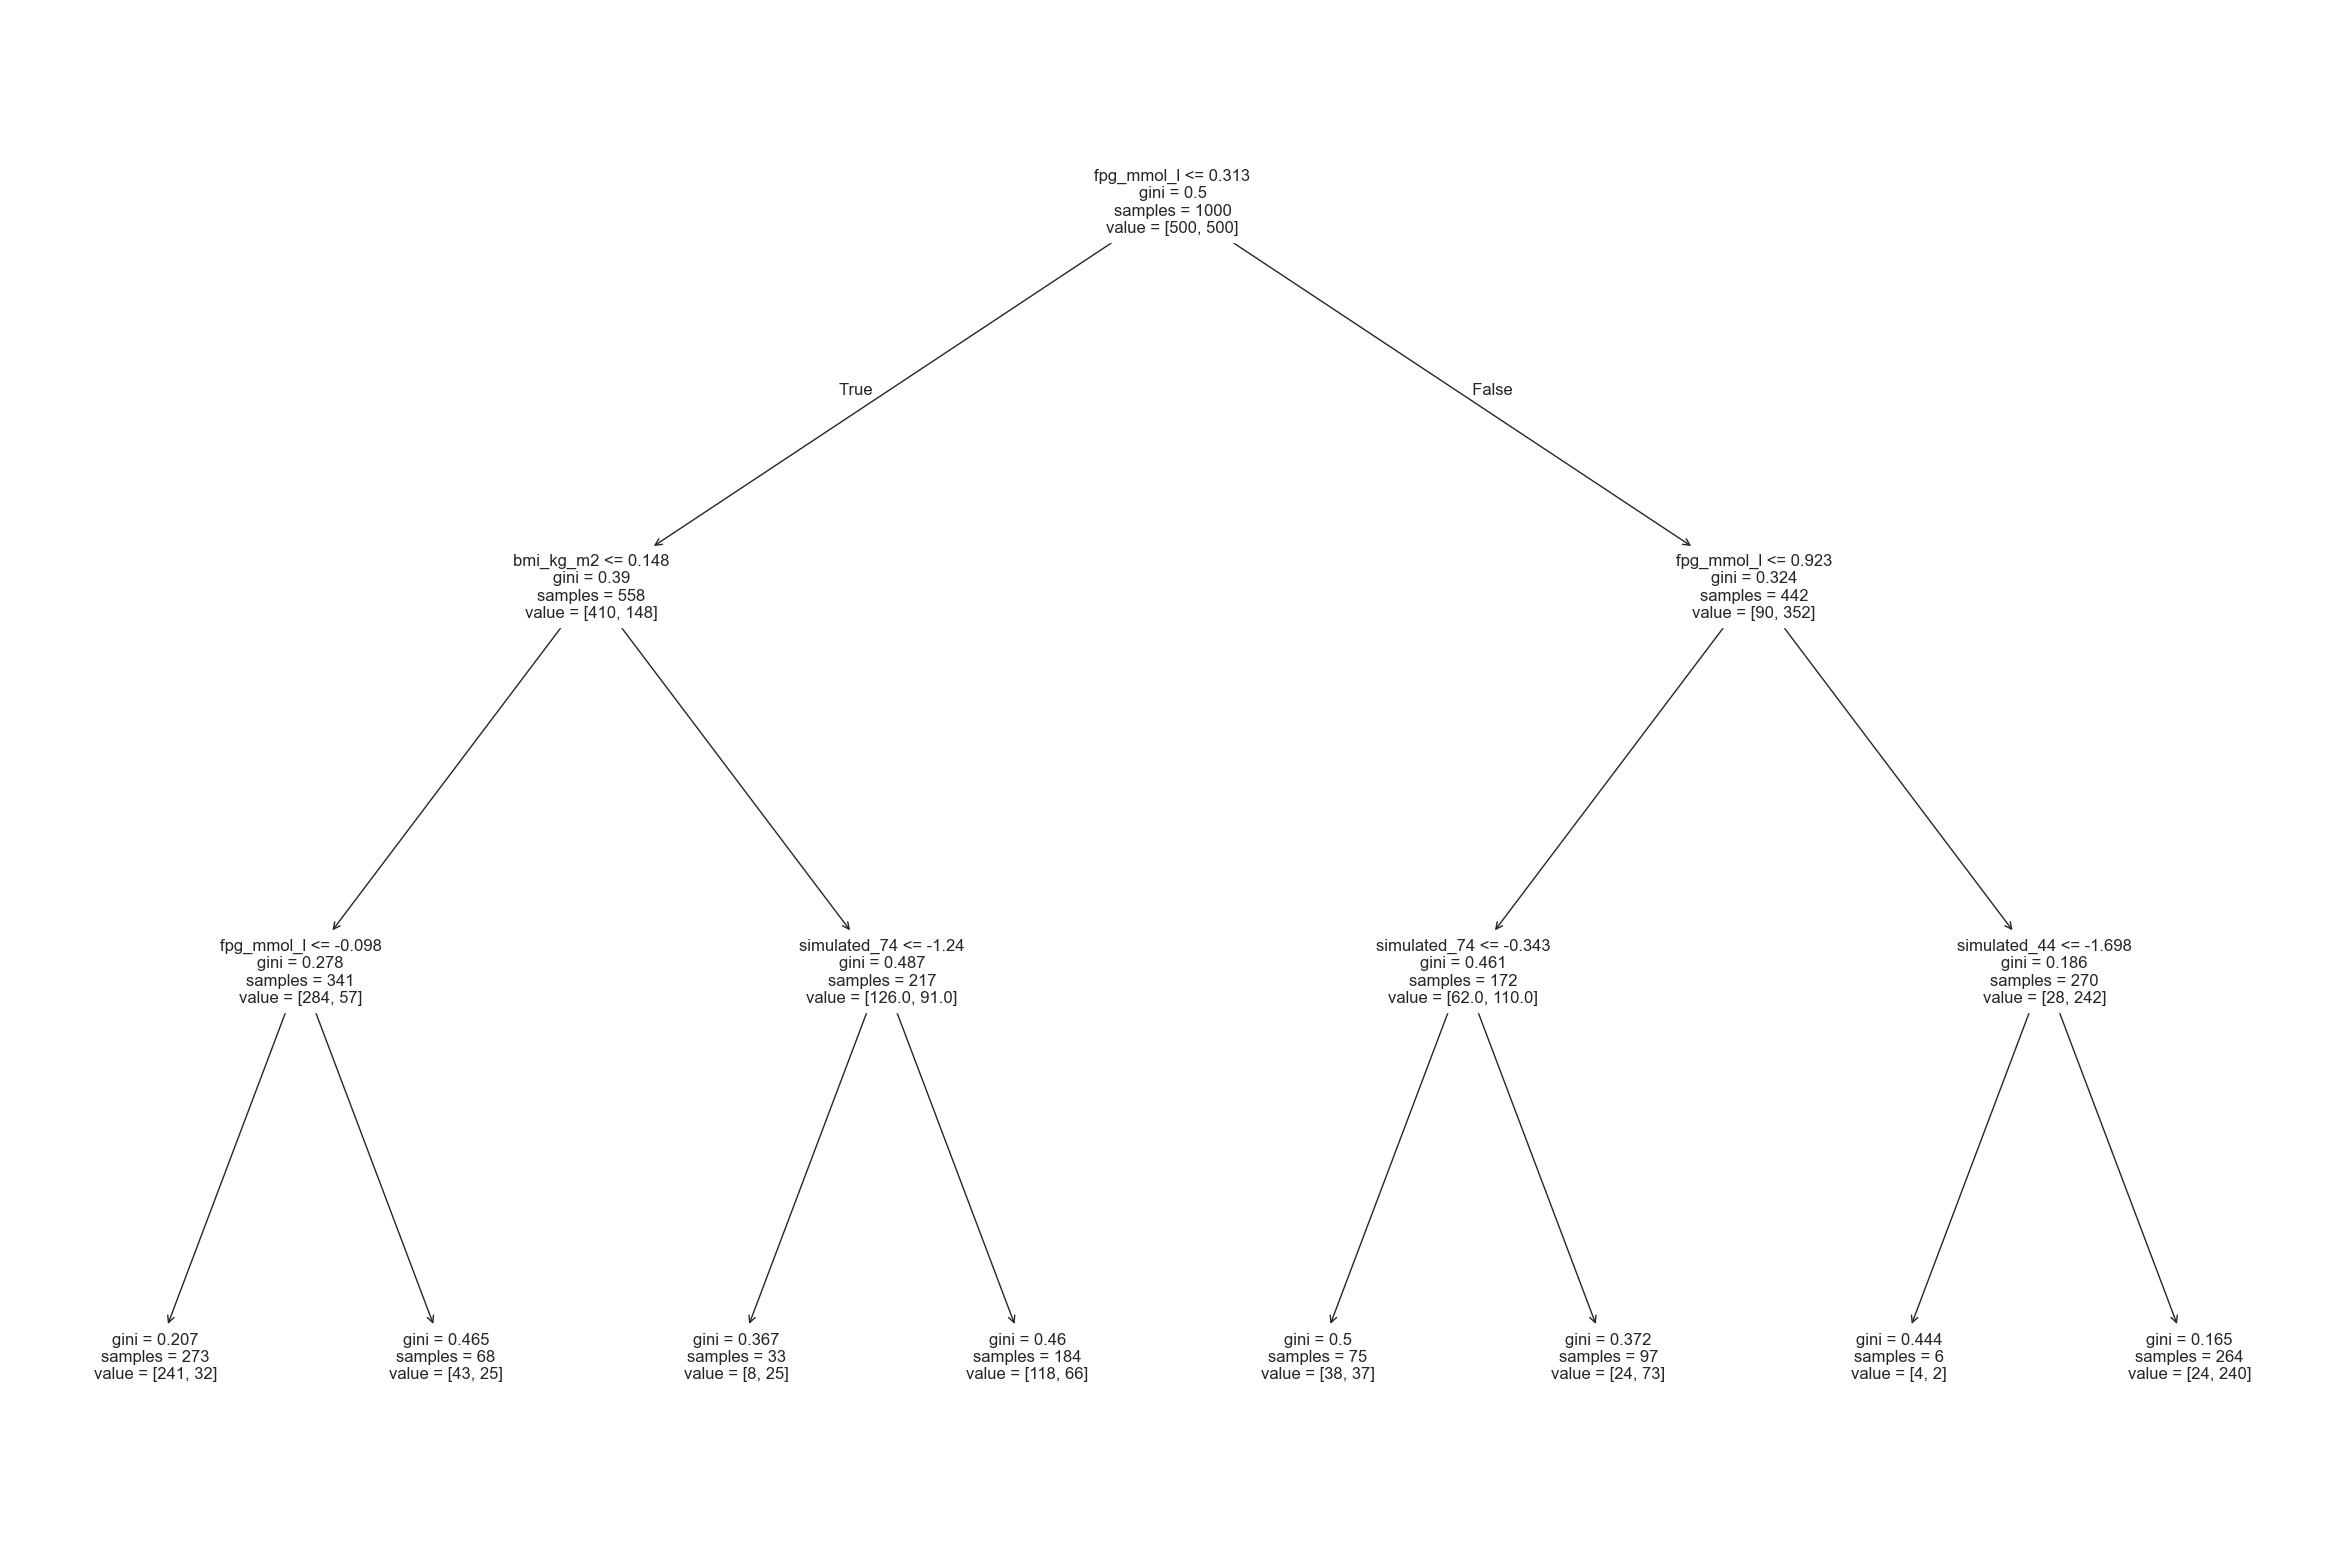

In [163]:
from sklearn import tree

#Fit a decision tree. 
#   Max depth controls how many rules/layers your tree has. 
#   Random state is so that the random part of the tree is replicable
clf=DecisionTreeClassifier(max_depth=3, random_state=0)
clf.fit(X_train, y)

#
# These parameters control the size of the resulting figure. If your model is too deep, you may need to make these values larger
plt.figure(figsize=(30,20))  
tree.plot_tree(clf, feature_names = X_train.columns, fontsize=12)
plt.show()

## 2.3 Exploring different metrics

We can also change the way that we evaluate model performance, again through the standardised interface provided by scikit-learn

A list of possible options are provided can be see at
https://scikit-learn.org/0.16/modules/model_evaluation.html

Examine the following:

1. Do different metrics ever change the ranking of which methods are best?
2. How do results compare on the internal and external predictions? Are they the same? Do they dramatically differ?
3. What happens when you adjust the amount of noise variables in the dataset?

In [164]:
# If you feel like generating a new dataset, uncomment this line. 
#X,y,X_ext,y_ext = workshop_fn.load_diabetes_data(diabetes_df_raw, add_n_features=100, sample_limit=1000, scale=True)

# Create a dictionary of multiple classifiers
# Use the scikit learn website to try and learn more about the parameters
#  https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html
#  https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html
clfs = {
    'Ridge':LogisticRegression(penalty='l2',C=10, tol=0.01), 
    'LogisticReg':LogisticRegression(penalty=None, solver="saga", tol=0.01), 
    'Lasso':LogisticRegression(penalty='l1', C=0.01, solver="saga", tol=0.01), 
    'RandomForest':RandomForestClassifier(random_state=0, n_estimators=500), 
    'DecisionTree':DecisionTreeClassifier(max_depth=5, random_state=0)
}

#Different metrics we might be interested in
metrics_dict = {
    'Accuracy':metrics.accuracy_score,
    'BalAccuracy':metrics.balanced_accuracy_score,
    'AUC':metrics.roc_auc_score,
    'LogLoss':metrics.log_loss,
    'PPV':metrics.precision_score,
    'NPV':metrics.precision_score,
}

#Helper function to return classifier name
def get_clf_name(estimator):
    return(estimator.__class__.__name__)

scores = {}
for clf_name,clf in clfs.items():
    scores[clf_name] = {}
    clf.fit(X, y)
    for metric_name, metric in metrics_dict.items():
        if metric_name=="AUC":
            scores[clf_name][metric_name + '_Internal']=metric(y, clf.predict_proba(X)[:,1])
            scores[clf_name][metric_name + '_External']=metric(y_ext, clf.predict_proba(X_ext)[:,1])
        else:
            scores[clf_name][metric_name + '_Internal']=metric(y, clf.predict(X))
            scores[clf_name][metric_name + '_External']=metric(y_ext, clf.predict(X_ext))

pd.options.display.float_format = '{:,.2f}'.format
pd.DataFrame(scores)


#clfs_res=[]
#print("{} total classifiers: ".format(len(clfs.items())), end="")
#for i, (clf_name, clf) in enumerate(clfs.items()):

,Ridge,LogisticReg,Lasso,RandomForest,DecisionTree
Accuracy_Internal,1.00,0.99,0.76,1.00,0.87
Accuracy_External,0.60,0.63,0.74,0.75,0.70
BalAccuracy_Internal,1.00,0.99,0.76,1.00,0.87
BalAccuracy_External,0.64,0.66,0.76,0.77,0.73
AUC_Internal,1.00,1.00,0.83,1.00,0.92
AUC_External,0.71,0.73,0.85,0.85,0.77
LogLoss_Internal,0.00,0.50,8.58,0.00,4.72
LogLoss_External,14.31,13.35,9.51,9.08,10.91
PPV_Internal,1.00,0.98,0.77,1.00,0.88
PPV_External,0.45,0.47,0.57,0.59,0.53


<hr style="border:2px solid gray"> </hr>

# Session 3: Train/test and cross-validation frameworks

In the previous example, we built model on entire dataset and evaluated its performance on the same data. Here, we will explore some alternative frameworks for doing this and will evaluate how model performance changes. We'll also start to explore different models and how key parameters can be altered to change prediction performance. 

## 3.1 Training and Test split

The following code examines training and testing a model on a single dataset and compares its performance to an external dataset in 3 scenarios:
 - Training on the entire dataset. Test on the same entire dataset. 
 - Training on a proportion (default 80%). Test on the same proportion. 
 - Training on a proportion (default 80%). Test on the remaining proportion. 
 
**Questions:**
1. Run this cell a few times. Which accuracies change? Why?
2. Which evaluation scenario is closest to the external data performance?
2. What is the best performance you can get by default? What is the worst performance you observe?
3. What happens to test performance as you add more noise variables?
4. Try changing parameters ('C' for the l2 penalized logistic regression, or max_depth for Random Forest)

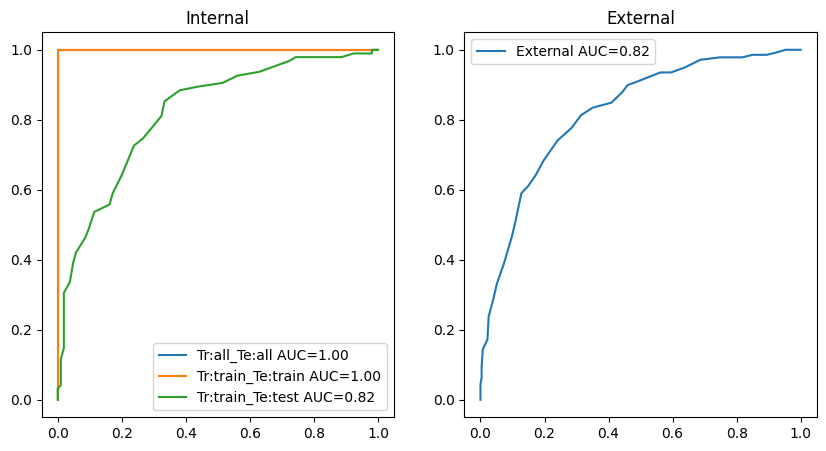

In [120]:
# If you feel like generating a new dataset, uncomment this line. 
#X,y,X_ext,y_ext = workshop_fn.load_diabetes_data(diabetes_df_raw, add_n_features=100, sample_limit=1000, scale=True)

#
# Select a model to construct
#
#clf=LogisticRegression(penalty=None, solver="saga", tol=0.01)
#clf=LogisticRegression(penalty='l2',C=10, tol=0.01)
clf=RandomForestClassifier(max_depth=None, random_state=0)

# Propotion of data to use for testing
test_prop = 0.2

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_prop)

scenarios = {
                "Tr:all_Te:all":    {"train":{'X':X,'y':y}, "test":{'X':X,'y':y}}, 
                "Tr:train_Te:train":  {"train":{'X':X_train,'y':y_train}, "test":{'X':X_train,'y':y_train}}, 
                "Tr:train_Te:test":   {"train":{'X':X_train,'y':y_train}, "test":{'X':X_test,'y':y_test}}
            }

fig, ax=plt.subplots(nrows=1,ncols=2, figsize=(10,5), dpi= 100, facecolor='w', edgecolor='k')

# Fit the model on the internal data, make predictions on whatever we are calling the test data and plot the results
for name, sc in scenarios.items():
    clf.fit(sc['train']['X'], sc['train']['y'])
    
    yp=clf.predict_proba(sc['test']['X'])[:,1]    
    workshop_fn.plot_roc(sc['test']['y'], yp, name, ax=ax[0])
   
# Fit the model on the external data and plot the results
clf.fit(X, y)
yp_ext=clf.predict_proba(X_ext)[:,1]
workshop_fn.plot_roc(y_ext, yp_ext, "External", ax=ax[1])
    
ax[0].legend(loc=0)
ax[0].title.set_text('Internal')
ax[1].legend(loc=0)
ax[1].title.set_text('External')

## 3.2 K-fold Cross-validation
Variability in the performance of different splits in the previous example motivates the use of K-fold cross validation. Here, we explore a few models and start to compare model performance.  

***Warning***: Be careful setting the values below. Setting the number of times to evaluate the classifiers too high and it will take too long to run for this workshop. 

**Questions:**
1. Run this cell a few times. What is the range of the scores that are observed?
2. Which model is the best? How do you determine this?
3. Play around with hyperparameters, what is the impact on model performance? Which models are sensitive to these choices?


4 total classifiers: 0123Done

<Axes: xlabel='clf', ylabel='auc'>

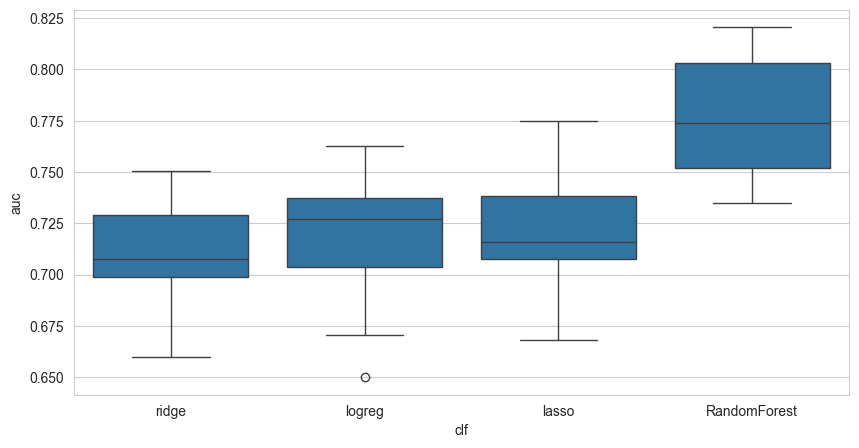

In [165]:
# If you feel like generating a new dataset, uncomment this line. 
#X,y,X_ext,y_ext = workshop_fn.load_diabetes_data(diabetes_df_raw, add_n_features=100, sample_limit=1000, scale=True)

clfs = {
    'ridge':LogisticRegression(penalty='l2',C=10, tol=0.01), 
    'logreg':LogisticRegression(penalty=None, solver="saga", tol=0.01), 
    'lasso':LogisticRegression(penalty='l1', C=100, solver="saga", tol=0.01), 
    'RandomForest':RandomForestClassifier(max_depth=20, random_state=0), 
}

def get_clf_name(estimator):
    return(estimator.__class__.__name__)

# This constructs n_splits * n_repeats classifiers. If these values are large, 
# or if classifier is slow it may take a long time    
n_folds=5
n_reps=3
cv = RepeatedKFold(n_splits=n_folds,n_repeats=n_reps)

clfs_res=[]
print("{} total classifiers: ".format(len(clfs.items())), end="")
for i, (clf_name, clf) in enumerate(clfs.items()):
    print(i, end="")
    
    # Record the  AUC for this classifier
    scores = cross_val_score(clf, X, y, cv=cv, scoring="roc_auc")
    
    #Turn the results into a data frame and add the classifier name
    clf_res=pd.DataFrame(data = scores, columns = ['auc']).assign(clf=clf_name)
    clfs_res.append(clf_res)
print("Done", end="")

#Make one big dataframe rather than a list of data.frames
clfs_res_merge = pd.concat(clfs_res)

#Now make a boxplot of the AUCs
fig, ax=plt.subplots(nrows=1,ncols=1, figsize=(10,5), dpi= 100, facecolor='w', edgecolor='k')
sns.boxplot(data=clfs_res_merge, y='auc', x="clf",ax=ax )

# Session 4. Overfitting via feature selection and model parameters


## 4.1 Feature discrimination over entire dataset
One naive way to remove noise is to look at the features one-by-one,  look at their ability to discriminate the dataset and only take the most useful into our model. This is flawed but is common in the literature. 

Lets take a look at the discriminatory ability of our features, here using an ANOVA, a common statistical test. We report the f-statistic (a measure of effect size) and p-value for each features. 

**Question:** 
1. How do measured and noisy simulated features compare?
2. What if we generate lots (n=10,000) noisy simulated features? How often can we distinguish noise and real signal?

In [166]:
# If you feel like generating a new dataset, uncomment this line. 
#X,y,X_ext,y_ext = workshop_fn.load_diabetes_data(diabetes_df_raw, add_n_features=100, sample_limit=1000, scale=True)

# Look at which features are important over the entire dataset
f, p = feature_selection.f_classif(X, y)
feature_scores = pd.DataFrame.from_dict({"feature":X.columns, "f-stat":f, "p.val":p})
feature_scores.sort_values(by="p.val", key=np.abs, ascending=True).iloc[0:10, :]

,feature,f-stat,p.val
7,fpg_mmol_l,432.14,0.00
4,bmi_kg_m2,97.90,0.00
9,triglyceride_mmol_l,58.73,0.00
3,weight_kg,43.42,0.00
5,sbp_mm_hg,41.86,0.00
6,dbp_mm_hg,24.41,0.00
12,alt_u_l,18.59,0.00
304,simulated_289,7.72,0.01
425,simulated_410,7.41,0.01
448,simulated_433,6.82,0.01


## 4.2 Demonstrating potential overfitting when selecting features before CV
Given we've ranked the features in terms of their discrinatory ability, we could now select some top amount (based on p-value, f-statistic or a feeling for how many features we need). 

But such an approach uses all of the information, and hence means there is no unsed data left for an untouched test set. 

To explore this impact, the code below plots classifier performance starting with a single most discrinimatory feature and increasing to the top 32 features. We plot the model performance in training and testing. 

Additionally, we plot the performance of constructing a model on all samples and evaluating the external dataset to show where the ideal would be. 

**Questions**
1. What are the trends in the performance of the model on the training data as we increase features?
2. What are the trends in the performance of the model on the test data as we increase features?
3. Where is the ideal number of features for the external data?
4. How often does number of features to achieve the highest "test" performance correspond to the hihgest external performance?
5. What happens if you run this cell a few times? How do results differ? Why do they change?


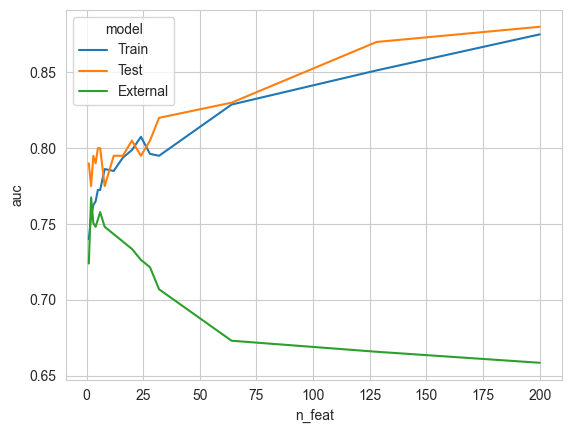

In [167]:
#X,y,X_ext,y_ext = workshop_fn.load_diabetes_data(diabetes_df_raw, add_n_features=100, sample_limit=1000, scale=True)

run_biased_analysis=True

#
# Pick your classifier
#
clf = LogisticRegression(penalty=None, tol=0.01, solver='saga')
#clf = RandomForestClassifier(max_depth=20, random_state=0)


# Set up a train/test split. You can change 'test_prop' to any (0-1) value
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_prop)

#Look at different numbers of features in the model. Remove any that are bigger than our current dataframe
n_feats = [1,2,3, 4,5, 6, 8,12,16,20, 24, 28, 32, 64, 128, 200, 1000]
n_feats = filter(lambda x: x<=len(X_train.columns), n_feats)
aucs=[]
for i in n_feats:

    # This is a clever trick, where we make a pipeline that first searches 
    # for the 'k' best features and then applies a classifier  to the filtered data. 
    #
    # Here, the best is based on an ANOVA F-statistic 
    # https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.f_classif.html
    # 
    # But you could use a range of other functions
    # https://scikit-learn.org/stable/modules/feature_selection.html#univariate-feature-selection
    clf_selected = make_pipeline(SelectKBest(f_classif, k=i),clf)

    #
    ## Two possibilities to choose from
    if run_biased_analysis == True:
        #   Biased: Use this to conduct feature selection on the entire dataset
        clf_selected.fit(X, y)
    else:
        #   Unbiased: Use this to conduct feature selection only on the training data
        clf_selected.fit(X_train, y_train)
      
    aucs.append(pd.DataFrame.from_dict({
        "n_feat": [i,i],
        "model" : ["Train", "Test"],
        "auc" : [clf_selected.score(X_train, y_train), 
                   clf_selected.score(X_test, y_test)]
    }))
    
    clf_selected.fit(X, y)
    aucs.append(pd.DataFrame.from_dict({
        "n_feat": [i],
        "model" : ["External"],
        "auc" : [clf_selected.score(X_ext, y_ext)]
    }))
    
    
    
aucs_df=pd.concat(aucs, ignore_index=True)
sns.set_style("whitegrid")

f=sns.lineplot(data=aucs_df, x="n_feat", y="auc", hue="model")
#f.set(xscale='log')

## 4.3 Nested cross-validation for feature selection and hyperparameter tuning

Rather than selecting the number of features to be included in a model (based on a random guess, or worse peeking at test results), we can instead conduct feature selection as part of cross validation. 

The code below runs two cross-validation loops (inner and outer), essentially running one loop on the training data (repeatededly breaking it into training and validation datasets) to understand how the number of features impacts performance. We then select the best number of features and evaluate the held-out testset. This is then repeated for the number of folds in the outer loop. 

While robust, the approach can be computationally expensive as we are building many models. 

**Warning** This code will take a few minutes. If you add in hyperparameter selection (by uncommenting param_grid),  this could take quite a while to run in Google Colab.

**Questions:**
1. Try generating a dataset with no noisy features and one with many? How much does performance vary?
2. How does performance vary if we change from a penalized regression to a random forest?

012

Text(0.5, 1.0, 'Comparison of mean accuracy obtained on the test sets with\nand without nested cross-validation')

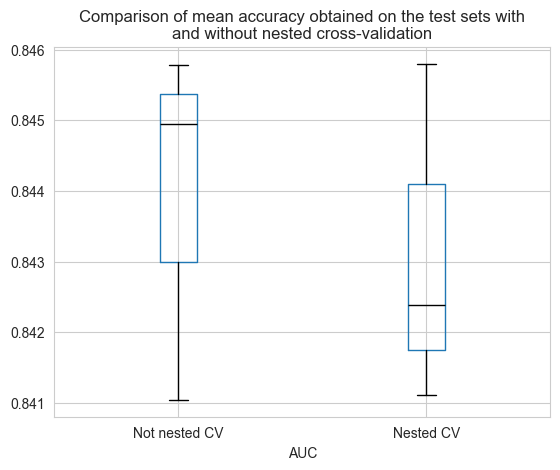

In [168]:
#X,y,X_ext,y_ext = workshop_fn.load_diabetes_data(diabetes_df_raw, add_n_features=100, sample_limit=1000, scale=True)

# Form a grid of parameters to look over
n_feats=[1,2,3, 4,5, 6, 8,12,16,20, 24, 28, 32]
n_feats=list(filter(lambda x: x<=len(X_train.columns), n_feats))

# Fit a regularised logistic regression
clf = LogisticRegression(penalty='l2', solver="saga", tol=0.01)
# Fit a random forest
#clf = RandomForestClassifier(max_depth=20, random_state=0)


#This line only optimises # of features selected. Next two also optimise model parameters but I think this is too slow for colab. 
param_grid = {"selectkbest__k": n_feats}
#param_grid = {"selectkbest__k": n_feats, "logisticregression__C": [0.01, 0.1, 1,5, 10, 50, 100]}
#param_grid = {"selectkbest__k": n_feats, "randomforestclassifier__max_depth": [5, 20, 50, 100]}


model_to_tune = make_pipeline(SelectKBest(f_classif),clf)
    
test_score_not_nested = []
test_score_nested = []

n_rep = 3
n_split_outer=5
n_split_inner=3

for i in range(n_rep):
    print(i, end='')

    #Set up two cross-validation helpers
    # Could also use RepeatedKFold() here but quickly becomes slow to fit
    inner_cv = KFold(n_splits=n_split_inner, shuffle=True, random_state=i)
    outer_cv = KFold(n_splits=n_split_outer, shuffle=True, random_state=i)

    # Warning: the code below is not very obvious
    
    # 1. Evaluate Non-nested parameter search and scoring
    #   GridSearchCV will take a model to fit and a grid of parameters and will evaluate performance 
    #   as a bunch of test/train splits. We can then select the model with the best score on the test data
    #   But this is biased as we evaluate the model based on the test data. 
    model = GridSearchCV(estimator=model_to_tune, param_grid=param_grid, cv=inner_cv, scoring="roc_auc")
    model.fit(X, y)
    test_score_not_nested.append(model.best_score_)

    # 2. Evaluate Nested CV with parameter optimization
    #     cross_val_score() will do all of our model fitting, first splitting the data into test and the remainder of the data then gets 
    #        split using GridSearchCV() into training and validation. The best model is selected from performance on the validation data
    #         and this final model is used to evaluate the held-out test data. 
    # Unbiased as model selection takes place on the validation, rather than test data. 
    model = GridSearchCV(estimator=model_to_tune, param_grid=param_grid, cv=inner_cv, scoring="roc_auc")
    test_score = cross_val_score(model, X, y, cv=outer_cv, scoring="roc_auc")
    test_score_nested.append(test_score.mean())


all_scores = {
    "Not nested CV": test_score_not_nested,
    "Nested CV": test_score_nested,
}
all_scores = pd.DataFrame(all_scores)

color = {"whiskers": "black", "medians": "black", "caps": "black"}
all_scores.plot.box(color=color, vert=True)
plt.xlabel("AUC")
plt.title("Comparison of mean accuracy obtained on the test sets with\n"
              "and without nested cross-validation")

## Final task
Using the above code, can you implement a scheme to answer the question "does BMI improve prediction of incident diabetes between 2 and 7 years from onset beyond age, sex, and blood glucose?".

Steps:

Copy the code in the previous section
Add call to a model with a specified feature subset (as in section Cell 1.3)
Compare boxplots from these two models

In [ ]:
# This is probably outside of the scope of this workshop! But if you get to here and have time to think about this, talk to me about your proposed solution. 